<span style="color:blue"><span style="font-size:30px">Classifying Clinically Actionable Genetic Mutations</span></span>

Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). 

Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.

An expert-annotated knowledge base where world-class researchers and oncologists have manually annotated thousands of mutations is available in 2 dataset files.

These 2 data set files, training_variants.zip and training_text.zip, are downloaded and unzipped in a local folder. We will change files extensions from txt to csv. 

In [1]:
#Pythin packages imported
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix,make_scorer,accuracy_score,log_loss,recall_score,precision_score
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords
import re
from IPython.display import Image
import math
from collections import Counter, defaultdict
from scipy.sparse import hstack
import warnings
warnings.filterwarnings("ignore")

In [2]:
#loading file in the python program. The separator in this file is a comma(we do not need to specify in this case)
medic_var=pd.read_csv('training_variants.csv')
#loading file in the python program. The separator in this file is a ||. names and skiprows parameters are used to separate column names and eliminate first row
medic_text=pd.read_csv('training_text.csv', sep='\|\|',names=['ID','Text'],skiprows=1)

In [3]:
medic_var.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


There are 3321 items and there 0 null values

In [4]:
medic_var.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


There are 4 fields.<br><br>__ID__ : Row indicator that in used to link these values to text variable in training_text file<br>
__Gene__ : Gene where genetic mutation is present<br>
__Varation__ :  Gene mutation type<br>
__Class__ : indicates the classification of the mutation (1 to 9)<br>

In [5]:
medic_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
ID      3321 non-null int64
Text    3316 non-null object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [6]:
medic_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
ID      3321 non-null int64
Text    3316 non-null object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


There are 3321 items and there 5 null values

In [7]:
medic_text.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


There are 2 fields:<br><br>
__ID__ : Row indicator that in used to link these values to Gene, variation and Class variables in the training_var file<br>
__Text__ : Medical text that refers to gene and its mutations<br>

We are going to check the __null values__ and the __space values__ in all the texts.

In [8]:
print("Space values",medic_text['Text'].str.isspace().sum())
print("Null values",medic_text['Text'].isna().sum())

Space values 0
Null values 5


In [9]:
#we are going to add the 2 dataframes and eliminate duplicate columns
medic=pd.concat([medic_var,medic_text],axis=1)
medic = medic.loc[:,~medic.columns.duplicated()]
medic=medic[['ID','Gene','Variation','Text','Class']]

In [10]:
medic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 5 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Text         3316 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(3)
memory usage: 129.8+ KB


In [11]:
medic.head()

,ID,Gene,Variation,Text,Class
0,0,FAM58A,Truncating Mutations,Cyclin-dependent kinases (CDKs) regulate a var...,1
1,1,CBL,W802*,Abstract Background Non-small cell lung canc...,2
2,2,CBL,Q249E,Abstract Background Non-small cell lung canc...,2
3,3,CBL,N454D,Recent evidence has demonstrated that acquired...,3
4,4,CBL,L399V,Oncogenic mutations in the monomeric Casitas B...,4


We can check that we have 5 null cells which belong to __Text__ column

In [12]:
medic[medic.isnull().any(axis=1)]

,ID,Gene,Variation,Text,Class
1109,1109,FANCA,S1088F,NaN,1
1277,1277,ARID5B,Truncating Mutations,NaN,1
1407,1407,FGFR3,K508M,NaN,6
1639,1639,FLT1,Amplification,NaN,6
2755,2755,BRAF,G596C,NaN,7


We have 2 options:<br>
<span style='color:blue'>1. Eliminate rows with null values</span><br>
<span style='color:blue'>2. Impute some text to these rows (for example 'Gene(stringvalue) '+ 'Variation(stringvalue')</span><br><br>
We are going to choose the elimination option because the null values total number is very low compared to __Text__ values total number.

In [13]:
medic.dropna(inplace=True)

In [14]:
medic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3316 entries, 0 to 3320
Data columns (total 5 columns):
ID           3316 non-null int64
Gene         3316 non-null object
Variation    3316 non-null object
Text         3316 non-null object
Class        3316 non-null int64
dtypes: int64(2), object(3)
memory usage: 155.4+ KB


We are going to check that there are no variants of Gene or Variation with added spaces

In [15]:
medic['Gene']=medic['Gene'].str.replace('\s+','')
medic['Variation']=medic['Variation'].str.replace('\s+','')

We are going to process the clinical text of __Text__ column.<br>
1. Suppression of any punctuation symbols and numbers <br>
2. Transformation to lower letters<br>
3. Suppression of stop words<br>

In [16]:
def text_processing(string):
    
    if type(string) == str:

        string = re.sub(r'[^\w\s]',' ',string)
        string= re.sub(r'\b[0-9]+\b\s*', ' ', string)
        string = re.sub(r"\s+", ' ', string)
    
        stop_words = stopwords.words('english')
        mylist=[]
        for word in string:
            mylist.append(word.lower())
        string=''.join(mylist) 
    
        word_tokens = word_tokenize(string) 
    
        filtered_sentence = [] 
        stop_words = stopwords.words('english')
        for w in word_tokens: 
            if w not in stop_words: 
                filtered_sentence.append(w) 

        string=' '.join(filtered_sentence)
    
    return string

In [17]:
medic['Text']=medic['Text'].apply(lambda x: text_processing(x))

In [18]:
medic.head()

,ID,Gene,Variation,Text,Class
0,0,FAM58A,TruncatingMutations,cyclin dependent kinases cdks regulate variety...,1
1,1,CBL,W802*,abstract background non small cell lung cancer...,2
2,2,CBL,Q249E,abstract background non small cell lung cancer...,2
3,3,CBL,N454D,recent evidence demonstrated acquired uniparen...,3
4,4,CBL,L399V,oncogenic mutations monomeric casitas b lineag...,4


We are going to split data into training set and test set to try our models

In [19]:
medic.drop(['ID'],axis=1,inplace=True)
y=medic['Class']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(medic, y, stratify=y, test_size=0.2,random_state=40)

In [21]:
print('Data points in train data:', X_train.shape[0])
print('Data points in test data:', X_test.shape[0])

Data points in train data: 2652
Data points in test data: 664


In [22]:
X_train.head()

,Gene,Variation,Text,Class
891,PDGFRA,G829R,activating mutations platelet derived growth f...,3
324,ROS1,G2032R,increasing number genetic alterations aberrant...,2
1758,IDH1,A134D,introduction somatic mutations human cytosolic...,4
2011,MAP2K1,I111P,utilizing genetic screen yeast saccharomyces c...,2
1947,MEF2B,D83V,mef2b gene encodes transcriptional activator f...,7


We are going to check the distribution of classes in training set and test set to validate further results. 

In [23]:
total_train=y_train.count()
y_train_distribution=y_train.value_counts().sort_index()
y_train_distribution_norm=y_train_distribution.apply(lambda x: x/total_train*100)
print(y_train_distribution_norm)

1    17.081448
2    13.612368
3     2.677225
4    20.701357
5     7.315234
6     8.220211
7    28.695324
8     0.565611
9     1.131222
Name: Class, dtype: float64


In [24]:
total_test=y_test.count()
y_test_distribution=y_test.value_counts().sort_index()
y_test_distribution_norm=y_test_distribution.apply(lambda x: x/total_test*100)
print(y_test_distribution_norm)

1    17.018072
2    13.704819
3     2.710843
4    20.632530
5     7.228916
6     8.283133
7    28.765060
8     0.602410
9     1.054217
Name: Class, dtype: float64


We can plot these results in 2 figures and check that the 2 distribution are very closed, due to the fact that stratify parameter of train_test_split function generates similar distributions.

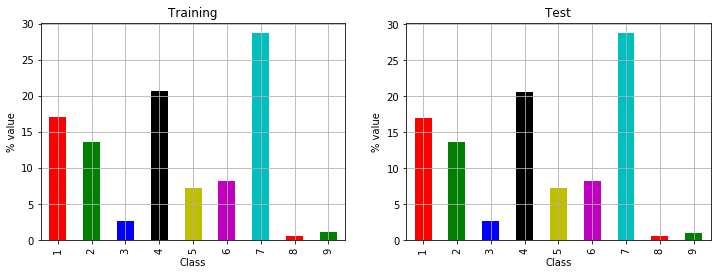

In [25]:
plt.figure(figsize=(12,4))
plt.subplot(121)
y_train_distribution_norm.plot(kind='bar',color=tuple(["r", "g","b","k","y","m","c"]))
plt.title('Training')
plt.xlabel('Class')
plt.ylabel('% value')
plt.grid()

plt.subplot(122)
y_test_distribution_norm.plot(kind='bar',color=tuple(["r", "g","b","k","y","m","c"]))
plt.title('Test')
plt.xlabel('Class')
plt.ylabel('% value')
plt.grid()

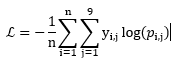

In [26]:
i = Image(filename='Log_loss_formula.png')
i

For evaluating our models we are going to use __log-loss__ metrics.<br>
This metric is defined in the formula above:<br>
i is the ith row number and j is the jth class

To better evaluate our results we have to compare them to an initial value. As our models are going to give some relationship between Gene, Variation, Text and Class, we are going to generate random numbers and check what value we are going to obtain with this random model. This value will be our initial value. Our machine learning models must give a better result than this initial value.

In [27]:
random_test=np.zeros((len(y_test),9))
for i in range(len(y_test)):
    rand_probs=np.random.rand(1,9)
    random_test[i]=rand_probs/np.sum(rand_probs)
print("log-loss on Test Data using Random Model",log_loss(y_test,random_test,eps=1e-15))

log-loss on Test Data using Random Model 2.4811863081577563


In [28]:
y_random =np.argmax(random_test, axis=1)
y_random=y_random+1

In [29]:
cm=confusion_matrix(y_test,y_random)

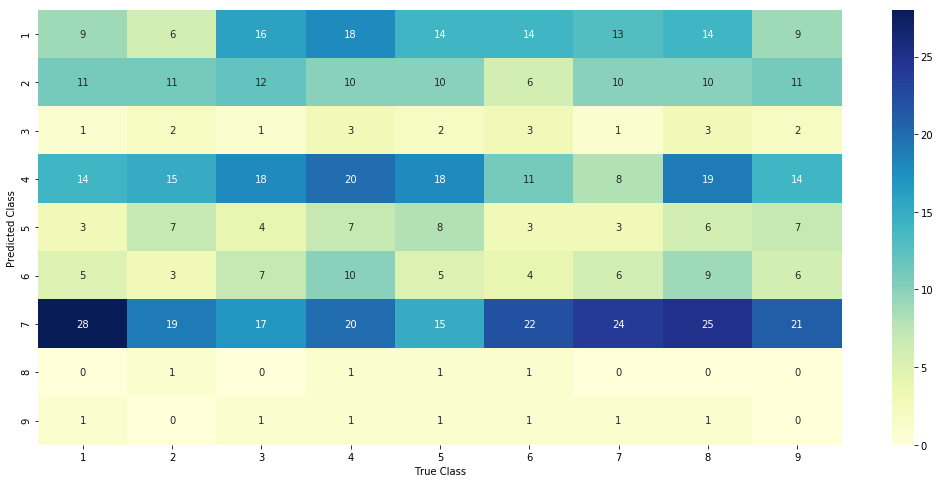

In [30]:
labels=[1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(18,8))
sns.heatmap(cm,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels)
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.show()

In [31]:
acc=(np.trace(cm)/np.sum(cm)*100)
print("In random prediction we obtain {0:.2f}% of accuracy".format(round(acc,2)))

In random prediction we obtain 11.60% of accuracy


Before testing the model for the whole independent variables, we are going to study these variables separately, apply the model and check the influence of each of them.
We are going to test first __Gene__, then __Variation__ and finally __Text__. 

<span style="color:red"><span style="font-size:15px">First Variable : Gene</span></span>

In [32]:
collection_genes=X_train['Gene'].value_counts()

In [33]:
collection_genes.head(10)

BRCA1     215
TP53      126
EGFR      112
BRCA2     103
PTEN      100
KIT        81
BRAF       77
ERBB2      59
ALK        52
PDGFRA     50
Name: Gene, dtype: int64

In [34]:
collection_genes.count()

246

We have 246 types of Genes in the train set and ,as we may notice in collection_genes series, 90% train set values are among the first 100 Gene values.<br>
We can see this distribution in the following figure:

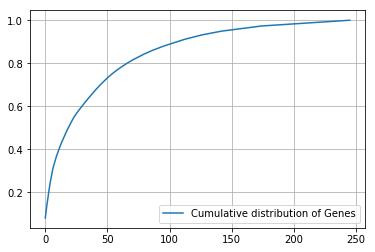

In [35]:
total = sum(collection_genes.values);
percentage = collection_genes.values/total;
cumul = np.cumsum(percentage)
plt.plot(cumul,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

Gene variable is a categorical variable. So it will be transformed in numerical values to be used furtherly by python librairies.

We will try 2 encoding methods: 

1. One-hot-encoder
2. Proportional encoder 

Concerning one_hot_encoder, we could use pandas function get_dummies but if there are too many values for categorical variable it may use a lot of memory. There is another function use by NLP which can give similar results using much less memory as it can optimize sparse matrices. This function is CountVectorizer. It will consider every value of 'Gene' variable as a text and will count every time a value appears. It generates a column for each different value of variable 'Gene'

In [36]:
#one-hot encoding
gene_vectorizer = CountVectorizer()
train_gene_onehotencoding = gene_vectorizer.fit_transform(X_train['Gene'])
test_gene_onehotencoding = gene_vectorizer.transform(X_test['Gene'])

In [37]:
print(train_gene_onehotencoding.shape)
print(test_gene_onehotencoding.shape)

(2652, 245)
(664, 245)


In [38]:
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'asxl1',
 'asxl2',
 'atm',
 'atrx',
 'aurka',
 'aurkb',
 'axin1',
 'axl',
 'b2m',
 'bap1',
 'bcl10',
 'bcl2',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgf3',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt3',
 'foxa1',
 'foxl2',
 'foxo1',
 'foxp1',
 'fubp1',
 'gata3',
 'gna11',
 'gnaq',
 'gnas',
 'h3f3a',
 'hist1h1c',
 '

This encoding is very straighforward but it generated a lot columns corresponding to unique values for variable 'Gene'. That is the reason why we are going to try another type of encoding to reduce the numer of generated columns.

The proportional encoding is based on the fact that we can calculate the number of times that a 'Gene' is linked to a 'Class'.

We are going to create a dictionary with __Gene__ as a key and a probabilities based array as a value. These probabilities are calculated as the number of times a Gene is linked to a Class divided by the total number of dataframe rows.
However, very often, there are Genes which are not linked to any Class. This fact appears mainly because of unbalanced classes. So we are going to use Laplace smoothing to assign a not null probability to these classes using 'alpha' parameter. 

In [39]:
#we will create a function that will be used for both variables Gene and Variation
def creating_dict(alpha,dataframe,column):
    
    count_features = dataframe[column].value_counts()
    
    dictionary=dict()
    
    for feature,feature_count in count_features.items():
        list_feature=[]
        for myclass in range(1,10):
            num_rows = dataframe.loc[(dataframe['Class']==myclass) & (dataframe[column]==feature)]
            list_feature.append((num_rows.shape[0] + alpha*1)/ (feature_count + 9*alpha))
        dictionary[feature]=list_feature
    return dictionary
    

In [40]:
#creation of training dictionary
mydict_train=creating_dict(1,X_train,'Gene')

Once we have a train dictionary, we are going to generate 9 columns based on the dictionary probabilities. If dataframe key is not in train dictionary, we will use the same probability for all 9 columns (p=1/9). (We tried before, classes distribution default probability, but the results were fairly bad)

In [41]:
# This function will be used for both 'Gene' and 'Variation'
def proportional_features(dataframe,column):
    
    count_train_features = X_train[column].value_counts()
    
    prop_columns = []
   
    for index, row in dataframe.iterrows():
        if row[column] in dict(count_train_features).keys():
            prop_columns.append(mydict_train[row[column]])
        else:
            prop_columns.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
            
    return np.array(prop_columns)

In [42]:
train_gene_proportionalencoding=proportional_features(X_train,'Gene')
test_gene_proportionalencoding=proportional_features(X_test,'Gene')

In [43]:
print(train_gene_proportionalencoding.shape)
print(test_gene_proportionalencoding.shape)

(2652, 9)
(664, 9)


We are going to check later several models with all relevant variables, but for testing variables separately to verify their significance, only a simple SGDClassifier model will be used. To test successfully log-loss metric we need predicted probabilities. Unfortunately not all the models can deliver both predicted values and predicted probabilities. In particular, SGDClassifier only delivers predicted values so an extra transformation to generate corresponding probabilities will be needed. There is a special model named CalibratedClassifierCV which can generate probabilities needed for log-loss metrics from original model fitting.

SGDClassifier results can vary depending on several hyperparameters but alpha parameter will be tuned to find optimal values.

OneHotEncoding

In [44]:
#SGDClassifier model tuning using onehotencoding for gene feature
param_grid = {'alpha': [0.00005,0.00006,0.00008,0.00009,0.0001,0.00011,0.00012,0.00013,0.00014]}
acc_scorer = make_scorer(accuracy_score)
clf = SGDClassifier(penalty='l2',loss='log',random_state=42)
grid_search=GridSearchCV(clf, param_grid, scoring=acc_scorer,
cv=5, return_train_score=True,verbose=0)
grid_result = grid_search.fit(train_gene_onehotencoding,y_train)
alpha=grid_result.best_params_['alpha']

In [45]:
#SGDClassifier model best result using onehotencoding for gene feature
model = SGDClassifier(alpha=alpha, penalty='l2', loss='log', random_state=42)
model.fit(train_gene_onehotencoding, y_train)
sig_model = CalibratedClassifierCV(model, method="sigmoid")
sig_model.fit(train_gene_onehotencoding, y_train)

y_pred = sig_model.predict_proba(train_gene_onehotencoding)
print("  log loss for train set is: {0:.4f}".format(log_loss(y_train, y_pred, labels=model.classes_, eps=1e-15)))
y_pred = sig_model.predict_proba(test_gene_onehotencoding)
print("  log loss for test  set is: {0:.4f}".format(log_loss(y_test, y_pred, labels=model.classes_, eps=1e-15)))

  log loss for train set is: 1.0445
  log loss for test  set is: 1.1739


ProportionalEncoding

In [46]:
#SGDClassifier model tuning using proportionalencoding for gene feature
param_grid = {'alpha': [0.00005,0.00006,0.00008,0.00009,0.0001,0.00011,0.00012,0.00013,0.00014]}
acc_scorer = make_scorer(accuracy_score)
clf = SGDClassifier(penalty='l2',loss='log',random_state=42)
grid_search=GridSearchCV(clf, param_grid, scoring=acc_scorer,
cv=5, return_train_score=True,verbose=0)
grid_result = grid_search.fit(train_gene_proportionalencoding,y_train)
alpha=grid_result.best_params_['alpha']

In [47]:
#SGDClassifier model best result using proportionalencoding for gene feature
model = SGDClassifier(alpha=alpha, penalty='l2', loss='log', random_state=42)
model.fit(train_gene_proportionalencoding, y_train)
sig_model = CalibratedClassifierCV(model, method="sigmoid")
sig_model.fit(train_gene_proportionalencoding, y_train)

y_pred = sig_model.predict_proba(train_gene_proportionalencoding)
print("  log loss for train set is: {0:.4f}".format(log_loss(y_train, y_pred, labels=model.classes_, eps=1e-15)))
y_pred = sig_model.predict_proba(test_gene_proportionalencoding)
print("  log loss for test  set is: {0:.4f}".format(log_loss(y_test, y_pred, labels=model.classes_, eps=1e-15)))

  log loss for train set is: 1.0611
  log loss for test  set is: 1.1779


Both encodings are giving similar results for SGDClassifier model.

Concerning proportional encoding we are going to check how many features are common to train and test sets.  

In [48]:
train_gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = train_gene_vectorizer.fit_transform(X_train['Gene'])
train_gene_features= train_gene_vectorizer.get_feature_names()

test_gene_vectorizer = CountVectorizer()
test_gene_feature_onehotCoding = test_gene_vectorizer.fit_transform(X_test['Gene'])
test_gene_features= test_gene_vectorizer.get_feature_names()

In [49]:
ratio=len(set(test_gene_features).intersection(set(train_gene_features)))/len(set(test_gene_features))*100

print("There are {0:.2f}% of test features present in train features".format(ratio))

There are 90.24% of test features present in train features


Concerning Proportional Encoding, the results will be better the higher the common features between train sets and test sets are.

<span style="color:red"><span style="font-size:15px">Second Variable : Variation</span></span>

In [50]:
collection_variations=X_train['Variation'].value_counts()

In [51]:
collection_variations.head(10)

TruncatingMutations    72
Amplification          58
Deletion               58
Fusions                27
Overexpression          6
E17K                    3
Q61H                    3
Q61R                    3
T58I                    3
G12V                    3
Name: Variation, dtype: int64

In [52]:
collection_variations.count()

2397

We have 2397 types of Variation in the train set and ,as we may notice in collection_variations series, only 5 types of (Gene) Variation appear more than 3 times. 2384 types of collection_variations appear twice or once.
We can see this distribution in the following figure:

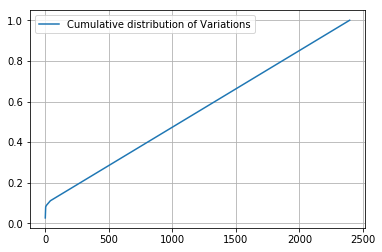

In [53]:
total = sum(collection_variations.values);
percentage = collection_variations.values/total;
cumul = np.cumsum(percentage)
plt.plot(cumul,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

As it has been done for Gene column, we are going to try 2 different encodings: OneHotEncoding and ProportionalEncoding.

OneHotEncoding

In [54]:
#one-hot encoding
variation_vectorizer = CountVectorizer()
train_variation_onehotencoding = variation_vectorizer.fit_transform(X_train['Variation'])
test_variation_onehotencoding = variation_vectorizer.transform(X_test['Variation'])

In [55]:
print(train_variation_onehotencoding.shape)
print(test_variation_onehotencoding.shape)

(2652, 2429)
(664, 2429)


In [56]:
#SGDClassifier model tuning using onehotencoding for variation feature
param_grid = {'alpha': [0.0005,0.0006,0.0008,0.0009,0.001,0.0011,0.0012,0.0013,0.0014]}
acc_scorer = make_scorer(accuracy_score)
clf = SGDClassifier(penalty='l2',loss='log',random_state=42)
grid_search=GridSearchCV(clf, param_grid, scoring=acc_scorer,
cv=5, return_train_score=True,verbose=0)
grid_result = grid_search.fit(train_variation_onehotencoding,y_train)
alpha=grid_result.best_params_['alpha']

In [57]:
#SGDClassifier model best result using onehotencoding for variation feature
model = SGDClassifier(alpha=alpha, penalty='l2', loss='log', random_state=42)
model.fit(train_variation_onehotencoding, y_train)
sig_model = CalibratedClassifierCV(model, method="sigmoid")
sig_model.fit(train_variation_onehotencoding, y_train)

y_pred = sig_model.predict_proba(train_variation_onehotencoding)
print("  log loss for train set is: {0:.4f}".format(log_loss(y_train, y_pred, labels=model.classes_, eps=1e-15)))
y_pred = sig_model.predict_proba(test_variation_onehotencoding)
print("  log loss for test  set is: {0:.4f}".format(log_loss(y_test, y_pred, labels=model.classes_, eps=1e-15)))

  log loss for train set is: 1.1148
  log loss for test  set is: 1.6763


ProportionalEncoding

In [58]:
mydict_train=creating_dict(1,X_train,'Variation')

In [59]:
train_variation_proportionalencoding=proportional_features(X_train,'Variation')
test_variation_proportionalencoding=proportional_features(X_test,'Variation')

In [60]:
#SGDClassifier model tuning using proportionalencoding for variation feature
param_grid = {'alpha': [0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14]}
acc_scorer = make_scorer(accuracy_score)
clf = SGDClassifier(penalty='l2',loss='log',random_state=42)
grid_search=GridSearchCV(clf, param_grid, scoring=acc_scorer,
cv=5, return_train_score=True,verbose=0)
grid_result = grid_search.fit(train_variation_proportionalencoding,y_train)
alpha=grid_result.best_params_['alpha']

In [61]:
#SGDClassifier model best result using proportionalencoding for variation feature
model = SGDClassifier(alpha=alpha, penalty='l2', loss='log', random_state=42)
model.fit(train_variation_proportionalencoding, y_train)
sig_model = CalibratedClassifierCV(model, method="sigmoid")
sig_model.fit(train_variation_proportionalencoding, y_train)

y_pred = sig_model.predict_proba(train_variation_proportionalencoding)
print("  log loss for train set is: {0:.4f}".format(log_loss(y_train, y_pred, labels=model.classes_, eps=1e-15)))
y_pred = sig_model.predict_proba(test_variation_proportionalencoding)
print("  log loss for test  set is: {0:.4f}".format(log_loss(y_test, y_pred, labels=model.classes_, eps=1e-15)))

  log loss for train set is: 0.2295
  log loss for test  set is: 1.8237


Concerning proportional encoding we are going to check how many features are common to train and test sets. 

In [62]:
train_variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = train_variation_vectorizer.fit_transform(X_train['Variation'])
train_variation_features= train_variation_vectorizer.get_feature_names()

test_variation_vectorizer = CountVectorizer()
test_variation_feature_onehotCoding = test_variation_vectorizer.fit_transform(X_test['Variation'])
test_variation_features= test_variation_vectorizer.get_feature_names()

In [63]:
ratio=len(set(test_variation_features).intersection(set(train_variation_features)))/len(set(test_variation_features))*100

print("There are {0:.2f}% of test features present in train features".format(ratio))

There are 6.01% of test features present in train features


As we have remarked for the 'Gene' variable, the higher the common features between training sets and test sets are, the better are the results for Proportional Encoding. Only 5.85% are common for both sets which implies not very good results(high overfitting).

<span style="color:red"><span style="font-size:15px">Third Variable : Text</span></span>

As variable __Text__ preprocessing might use a lot of memory, it cannot be preprocessed in the same way as the first 2 variables, __Gene__ and __Variation__.

OneHotEncoding

In [64]:
#in this case the vectorisation matches with text words. Only words that appear twice 
#will be considered
text_vectorizer = CountVectorizer(min_df=2)

train_text_onehotencoding = text_vectorizer.fit_transform(X_train['Text'])

train_text_features= text_vectorizer.get_feature_names()

print("Number of unique words in train set :", len(train_text_features))

Number of unique words in train set : 79287


As there are words which appear several times in the same text, the sparse matrix generated may have values much greater than 1. So when we will use the 3 variables together in OneHotEncoding method and as the other variables will have values between 0 and 1. So the columns generated for the variable "Text" will have to be [0,1] normalised for further use. So we will normalise training and test sets.

In [65]:
train_text_onehotencoding = normalize(train_text_onehotencoding, axis=0)

test_text_onehotencoding = text_vectorizer.transform(X_test['Text'])

test_text_onehotencoding = normalize(test_text_onehotencoding, axis=0)

In [66]:
#SGDClassifier model tuning using onehotencoding for text feature
param_grid = {'alpha': [0.0005,0.0006,0.007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013,0.0014]}
acc_scorer = make_scorer(accuracy_score)
clf = SGDClassifier(penalty='l2',loss='log',random_state=42)
grid_search=GridSearchCV(clf, param_grid, scoring=acc_scorer,
cv=5, return_train_score=True,verbose=0)
grid_result = grid_search.fit(train_text_onehotencoding,y_train)
alpha=grid_result.best_params_['alpha']

In [67]:
#SGDClassifier model best result using onehotencoding for text feature
model = SGDClassifier(alpha=alpha, penalty='l2', loss='log', random_state=42)
model.fit(train_text_onehotencoding, y_train)
sig_model = CalibratedClassifierCV(model, method="sigmoid")
sig_model.fit(train_text_onehotencoding, y_train)

y_pred = sig_model.predict_proba(train_text_onehotencoding)
print("  log loss for train set is: {0:.4f}".format(log_loss(y_train, y_pred, labels=model.classes_, eps=1e-15)))
y_pred = sig_model.predict_proba(test_text_onehotencoding)
print("  log loss for test  set is: {0:.4f}".format(log_loss(y_test, y_pred, labels=model.classes_, eps=1e-15)))

  log loss for train set is: 0.7471
  log loss for test  set is: 1.1002


ProportionalEncoding

For this particular variable __Text__, the ProportionalEncoder will apply in a different way.<br> We create a function to generate a vocabulary for the whole training set, and a vocabulary for the texts linked to a determined Class.

In [68]:
def create_vocabulary(dataframe):
    vocabulary = defaultdict(int)
    for index, row in dataframe.iterrows():
        for word in row['Text'].split():
            vocabulary[word] +=1
    return vocabulary

In [69]:
vocab_list = []
# vocab_list =[] contains 9 dictionaries and each one corresponds to a class
for i in range(1,10):
    vocabulary_text = X_train[X_train['Class']==i]
    # build a word dict based on the words in that class
    vocab_list.append(create_vocabulary(vocabulary_text))
    # append it to vocab_list
total_vocab = create_vocabulary(X_train)

In [70]:
#we are going to get the proportion for each class for the sum of number of times that words 
#appear in the texts of a class divided by the sum of the number of times that words appear 
#in all the texts of training set
#we use log and the exp to void overflow calculation problems
def text_proportionalencoding(df):
    text_feature_proportionalencoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['Text'].split():
                sum_prob += math.log(((vocab_list[i].get(word,0)+1)/(total_vocab.get(word,0)+9)))
            text_feature_proportionalencoding[row_index][i] = math.exp(sum_prob/len(row['Text'].split()))
            row_index += 1
    return text_feature_proportionalencoding

In [71]:
train_text_proportionalencoding=text_proportionalencoding(X_train)
test_text_proportionalencoding=text_proportionalencoding(X_test)

In [72]:
test_text_proportionalencoding=(test_text_proportionalencoding.T/test_text_proportionalencoding.sum(axis=1)).T
train_text_proportionalencoding=(train_text_proportionalencoding.T/train_text_proportionalencoding.sum(axis=1)).T

In [73]:
#SGDClassifier model tuning using proportionalencoding for text feature
param_grid = {'alpha': [0.000005,0.000006,0.000007,0.000008,0.000009,0.00001,0.000011,0.000012,0.000013,0.000014]}
acc_scorer = make_scorer(accuracy_score)
clf = SGDClassifier(penalty='l2',loss='log',random_state=42)
grid_search=GridSearchCV(clf, param_grid, scoring=acc_scorer,
cv=5, return_train_score=True,verbose=0)
grid_result = grid_search.fit(train_text_proportionalencoding,y_train)
alpha=grid_result.best_params_['alpha']

In [74]:
#SGDClassifier model best result using proportionalencoding for text feature
model = SGDClassifier(alpha=alpha, penalty='l2', loss='log', random_state=42)
model.fit(train_text_proportionalencoding, y_train)
sig_model = CalibratedClassifierCV(model, method="sigmoid")
sig_model.fit(train_text_proportionalencoding, y_train)

y_pred = sig_model.predict_proba(train_text_proportionalencoding)
print("  log loss for train set is: {0:.4f}".format(log_loss(y_train, y_pred, labels=model.classes_, eps=1e-15)))
y_pred = sig_model.predict_proba(test_text_proportionalencoding)
print("  log loss for test  set is: {0:.4f}".format(log_loss(y_test, y_pred, labels=model.classes_, eps=1e-15)))

  log loss for train set is: 0.9489
  log loss for test  set is: 1.1567


Concerning proportional encoding we are going to check how many features are common to train and test sets. 

In [75]:
train_text_vectorizer = CountVectorizer(min_df=2)
train_text_features_onehotCoding = train_text_vectorizer.fit_transform(X_train['Text'])
train_text_features= train_text_vectorizer.get_feature_names()

test_text_vectorizer = CountVectorizer(min_df=2)
test_text_features_onehotCoding = test_text_vectorizer.fit_transform(X_test['Text'])
test_text_features= test_text_vectorizer.get_feature_names()

In [76]:
ratio=len(set(test_text_features).intersection(set(train_text_features)))/len(set(test_text_features))*100

print("There are {0:.2f}% of test features present in train features".format(ratio))

There are 94.12% of test features present in train features


The 3 variables are meaningful to predict __Class__, but __Gene__ and __Text__ give a better prediction result than __Variation__.  

<span style="color:red"><span style="font-size:15px">Combining variables : Gene, Variation and Text</span></span>

We are going to combine the 3 variables taking into account that we do not have dataframes anymore. We are going to use special functions (hstack) to merge sparse matrices and arrays. This stack operation changes the type of sparse matrix, array and we need to compress the sparse matrix result.

In [77]:
print("Shape of Gene trainset     ",train_gene_onehotencoding.shape)
print("Shape of Variation trainset",train_variation_onehotencoding.shape)
print("Shape of Text trainset     ",train_text_onehotencoding.shape)

Shape of Gene trainset      (2652, 245)
Shape of Variation trainset (2652, 2429)
Shape of Text trainset      (2652, 79287)


In [78]:
print("Shape of Gene testset     ",test_gene_onehotencoding.shape)
print("Shape of Variation testset",test_variation_onehotencoding.shape)
print("Shape of Text testset     ",test_text_onehotencoding.shape)

Shape of Gene testset      (664, 245)
Shape of Variation testset (664, 2429)
Shape of Text testset      (664, 79287)


In [79]:
train_var_onehotencoding = hstack((train_gene_onehotencoding,train_variation_onehotencoding))
X_train_onehotencoding=hstack((train_var_onehotencoding,train_text_onehotencoding)).tocsr()

In [80]:
test_var_onehotencoding = hstack((test_gene_onehotencoding,test_variation_onehotencoding))
X_test_onehotencoding=hstack((test_var_onehotencoding,test_text_onehotencoding)).tocsr()

In [81]:
print("OneHotEncoding")
print("Training shape",X_train_onehotencoding.shape)
print("Test Shape    ",X_test_onehotencoding.shape)

OneHotEncoding
Training shape (2652, 81961)
Test Shape     (664, 81961)


In [82]:
train_var_proportionalencoding=np.hstack((train_gene_proportionalencoding,train_variation_proportionalencoding))
X_train_proportionalencoding=np.hstack((train_var_proportionalencoding,train_text_proportionalencoding))

In [83]:
test_var_proportionalencoding=np.hstack((test_gene_proportionalencoding,test_variation_proportionalencoding))
X_test_proportionalencoding=np.hstack((test_var_proportionalencoding,test_text_proportionalencoding))

In [84]:
print("ProportionalEncoding")
print("Training shape",X_train_proportionalencoding.shape)
print("Test Shape    ",X_test_proportionalencoding.shape)

ProportionalEncoding
Training shape (2652, 27)
Test Shape     (664, 27)


Once we have combine all the variables we are going to test several machine learning models

<span style="color:red"><span style="font-size:25px">SGDClassifier basic</span></span>

<span style="color:blue"><span style="font-size:20px">OneHotEncoding</span></span>

In [85]:
#SGDClassifier model tuning using onehotencoding for all the features
param_grid = {'alpha': [0.0005,0.0006,0.007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013,0.0014]}
acc_scorer = make_scorer(accuracy_score)
clf = SGDClassifier(penalty='l2',loss='log',random_state=42)
grid_search=GridSearchCV(clf, param_grid, scoring=acc_scorer,
cv=5, return_train_score=True,verbose=0)
grid_result = grid_search.fit(X_train_onehotencoding,y_train)
alpha=grid_result.best_params_['alpha']

In [86]:
#SGDClassifier model best result using onehotencoding for all the feature
model = SGDClassifier(alpha=alpha, penalty='l2', loss='log', random_state=42)
model.fit(X_train_onehotencoding, y_train)
sig_model = CalibratedClassifierCV(model, method="sigmoid")
sig_model.fit(X_train_onehotencoding, y_train)

y_pred = sig_model.predict_proba(X_train_onehotencoding)
print("  log loss for train set is: {0:.4f}".format(log_loss(y_train, y_pred, labels=model.classes_, eps=1e-15)))
y_pred = sig_model.predict_proba(X_test_onehotencoding)
print("  log loss for test  set is: {0:.4f}".format(log_loss(y_test, y_pred, labels=model.classes_, eps=1e-15)))

  log loss for train set is: 0.6084
  log loss for test  set is: 1.0428


<span style='font-size:20px'>Accuracy model will be now calculated</span>

In [87]:
#predicted classes are given in the range[0,8], 1 will be added to match with our Class numbers
y_prediction =np.argmax(y_pred, axis=1)
y_prediction=y_prediction+1

In [88]:
cm=confusion_matrix(y_test,y_prediction)

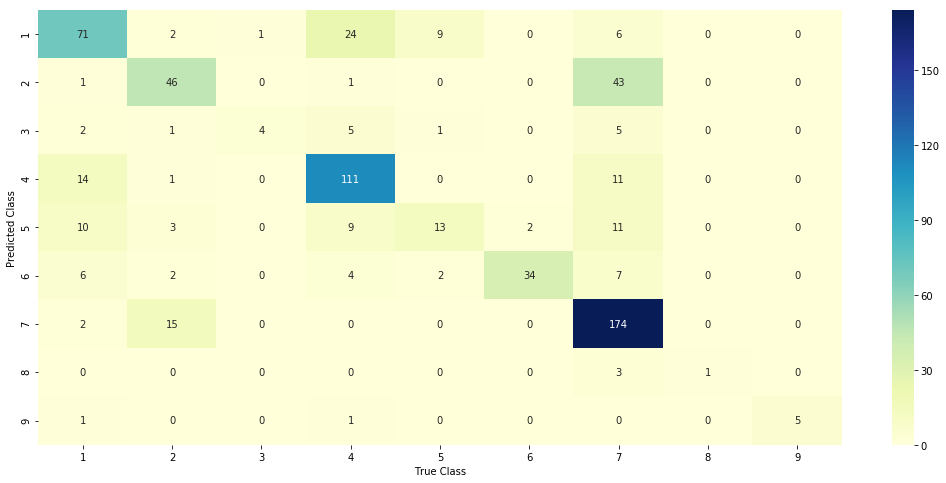

In [89]:
labels=[1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(18,8))
sns.heatmap(cm,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels,fmt='g')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.show()

In [90]:
acc=(np.trace(cm)/np.sum(cm)*100)
print("In SGDClassifier (onehotencoding) we obtain {0:.2f}% of accuracy".format(round(acc,2)))

In SGDClassifier (onehotencoding) we obtain 69.13% of accuracy


<span style="color:blue"><span style="font-size:20px">ProportionalEncoding</span></span>

In [91]:
#SGDClassifier model tuning using proportionalencoding for all the features
param_grid = {'alpha': [0.001,0.0011,0.0012,0.0013,0.0014]}
acc_scorer = make_scorer(accuracy_score)
clf = SGDClassifier(penalty='l2',loss='log',random_state=42)
grid_search=GridSearchCV(clf, param_grid, scoring=acc_scorer,
cv=5, return_train_score=True,verbose=0)
grid_result = grid_search.fit(X_train_proportionalencoding,y_train)
alpha=grid_result.best_params_['alpha']

In [92]:
#SGDClassifier model best result using proportionalencoding for all the features
model = SGDClassifier(alpha=alpha, penalty='l2', loss='log', random_state=42)
model.fit(X_train_proportionalencoding, y_train)
sig_model = CalibratedClassifierCV(model, method="sigmoid")
sig_model.fit(X_train_proportionalencoding, y_train)

y_pred = sig_model.predict_proba(X_train_proportionalencoding)
print("  log loss for train set is: {0:.4f}".format(log_loss(y_train, y_pred, labels=model.classes_, eps=1e-15)))
y_pred = sig_model.predict_proba(X_test_proportionalencoding)
print("  log loss for test  set is: {0:.4f}".format(log_loss(y_test, y_pred, labels=model.classes_, eps=1e-15)))

  log loss for train set is: 0.5860
  log loss for test  set is: 1.1201


<span style='font-size:20px'>Model accuracy will be now calculated</span>

In [93]:
y_prediction =np.argmax(y_pred, axis=1)
y_prediction=y_prediction+1

In [94]:
cm=confusion_matrix(y_test,y_prediction)

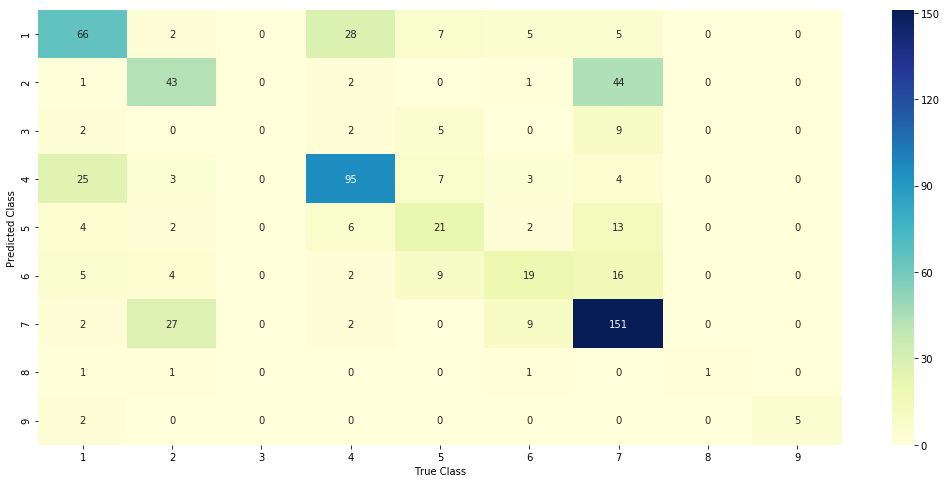

In [95]:
labels=[1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(18,8))
sns.heatmap(cm,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels,fmt='g')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.show()

In [96]:
acc=(np.trace(cm)/np.sum(cm)*100)
print("In SGDClassifier (proportionalencoding) we obtain {0:.2f}% of accuracy".format(round(acc,2)))

In SGDClassifier (proportionalencoding) we obtain 60.39% of accuracy


<span style="color:red"><span style="font-size:25px">SGDClassifier balanced weights</span></span>

<span style="color:blue"><span style="font-size:20px">OneHotEncoding</span></span>

In [97]:
#balanced SGDClassifier model tuning using onehotencoding for all the features
param_grid = {'alpha': [0.0005,0.0006,0.007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013,0.0014]}
acc_scorer = make_scorer(accuracy_score)
clf = SGDClassifier(penalty='l2',loss='log',random_state=42,class_weight='balanced')
grid_search=GridSearchCV(clf, param_grid, scoring=acc_scorer,
cv=5, return_train_score=True,verbose=0)
grid_result = grid_search.fit(X_train_onehotencoding,y_train)
alpha=grid_result.best_params_['alpha']

0.0013

In [98]:
#balanced SGDClassifier model best result using onehotencoding for all the features
model = SGDClassifier(alpha=alpha, penalty='l2', loss='log', random_state=42,class_weight='balanced')
model.fit(X_train_onehotencoding, y_train)
sig_model = CalibratedClassifierCV(model, method="sigmoid")
sig_model.fit(X_train_onehotencoding, y_train)

y_pred = sig_model.predict_proba(X_train_onehotencoding)
print("  log loss for train set is: {0:.4f}".format(log_loss(y_train, y_pred, labels=model.classes_, eps=1e-15)))
y_pred = sig_model.predict_proba(X_test_onehotencoding)
print("  log loss for test  set is: {0:.4f}".format(log_loss(y_test, y_pred, labels=model.classes_, eps=1e-15)))

  log loss for train set is: 0.6164
  log loss for test  set is: 1.0334


<span style='font-size:20px'>Accuracy model will be now calculated</span>

In [99]:
y_prediction =np.argmax(y_pred, axis=1)
y_prediction=y_prediction+1

In [100]:
cm=confusion_matrix(y_test,y_prediction)

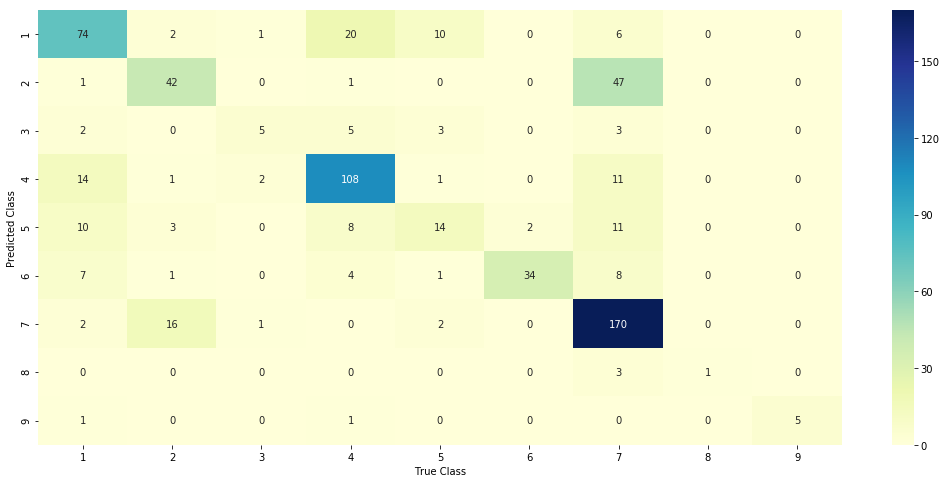

In [101]:
labels=[1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(18,8))
sns.heatmap(cm,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels,fmt='g')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.show()

In [102]:
acc=(np.trace(cm)/np.sum(cm)*100)
print("For balanced SGDClassifier (onehotencoding) we obtain {0:.2f}% of accuracy".format(round(acc,2)))

For balanced SGDClassifier (onehotencoding) we obtain 68.22% of accuracy


<span style="color:blue"><span style="font-size:20px">ProportionalEncoding</span></span>

In [103]:
#balanced SGDClassifier model tuning using onehotencoding for all the features
param_grid = {'alpha': [0.001,0.0011,0.0012,0.0013,0.0014]}
acc_scorer = make_scorer(accuracy_score)
clf = SGDClassifier(penalty='l2',loss='log',random_state=42,class_weight='balanced')
grid_search=GridSearchCV(clf, param_grid, scoring=acc_scorer,
cv=5, return_train_score=True,verbose=0)
grid_result = grid_search.fit(X_train_proportionalencoding,y_train)
alpha=grid_result.best_params_['alpha']

In [104]:
#balanced SGDClassifier model best result using proportionalencoding for all the features
model = SGDClassifier(alpha=alpha, penalty='l2', loss='log', random_state=42,class_weight='balanced')
model.fit(X_train_proportionalencoding, y_train)
sig_model = CalibratedClassifierCV(model, method="sigmoid")
sig_model.fit(X_train_proportionalencoding, y_train)

y_pred = sig_model.predict_proba(X_train_proportionalencoding)
print("  log loss for train set is: {0:.4f}".format(log_loss(y_train, y_pred, labels=model.classes_, eps=1e-15)))
y_pred = sig_model.predict_proba(X_test_proportionalencoding)
print("  log loss for test  set is: {0:.4f}".format(log_loss(y_test, y_pred, labels=model.classes_, eps=1e-15)))

  log loss for train set is: 0.5717
  log loss for test  set is: 1.1049


<span style='font-size:20px'>Accuracy model will be now calculated</span>

In [105]:
y_prediction =np.argmax(y_pred, axis=1)
y_prediction=y_prediction+1

In [106]:
cm=confusion_matrix(y_test,y_prediction)

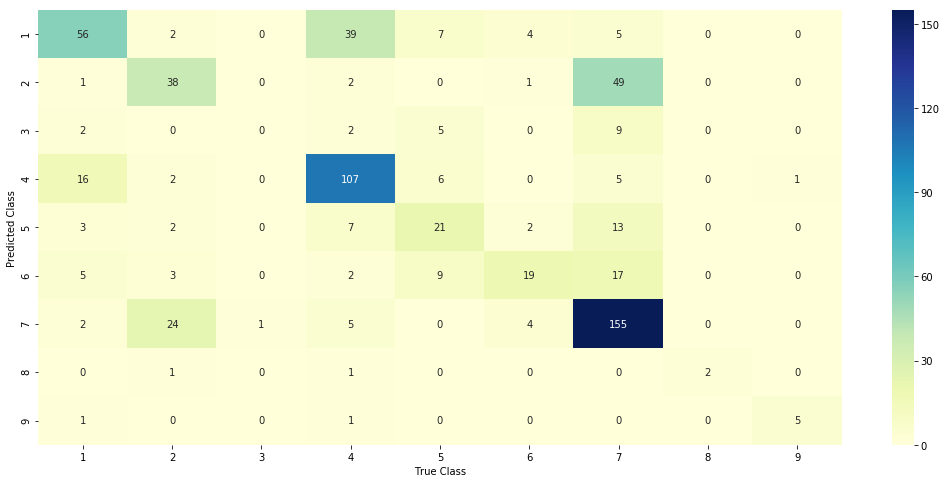

In [107]:
labels=[1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(18,8))
sns.heatmap(cm,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels,fmt='g')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.show()

In [108]:
acc=(np.trace(cm)/np.sum(cm)*100)
print("For balanced SGDClassifier (ProportionalEncoding) we obtain {0:.2f}% of accuracy".format(round(acc,2)))

For balanced SGDClassifier (ProportionalEncoding) we obtain 60.69% of accuracy


For next models we will tune directly complete model and choose the best parameters instead of using GridsearchCV. 

<span style="color:red"><span style="font-size:25px">KNN Neighbour Classifier</span></span>

<span style="color:blue"><span style="font-size:20px">OneHotEncoding</span></span>

In [109]:
#KNNneighbours Classifier tuning with onehotencoding
neighbour = [1,2,3,4,5,6]
test_log_error_array=[]
for i in neighbour:
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(X_train_onehotencoding, y_train)
    sig_model = CalibratedClassifierCV(model, method="sigmoid")
    sig_model.fit(X_train_onehotencoding, y_train)
    y_pred = sig_model.predict_proba(X_test_onehotencoding)
    test_log_error_array.append(log_loss(y_test, y_pred, labels=model.classes_, eps=1e-15))
    print("Neighbour's number value = {:>7}  log loss is: {:>12}".format(i,log_loss(y_test, y_pred, labels=model.classes_, eps=1e-15)))

Neighbour's number value =       1  log loss is: 1.317613127043413
Neighbour's number value =       2  log loss is: 1.2686036559197338
Neighbour's number value =       3  log loss is: 1.2503652776453584
Neighbour's number value =       4  log loss is: 1.2283279865585466
Neighbour's number value =       5  log loss is: 1.2297875620959307
Neighbour's number value =       6  log loss is: 1.2501937915848202


In [110]:
#KNNneighbours Classifier best result using onehotencoding
best_neighbour = np.argmin(test_log_error_array)
model = KNeighborsClassifier(n_neighbors=neighbour[best_neighbour])
model.fit(X_train_onehotencoding, y_train)
sig_model = CalibratedClassifierCV(model, method="sigmoid")
sig_model.fit(X_train_onehotencoding, y_train)

y_pred = sig_model.predict_proba(X_train_onehotencoding)
print("Neighbour's number values =", neighbour[best_neighbour], "Train log loss is:",log_loss(y_train, y_pred, labels=model.classes_, eps=1e-15))

y_pred = sig_model.predict_proba(X_test_onehotencoding)
print("Neighbour's number values =", neighbour[best_neighbour], "Test  log loss is:",log_loss(y_test, y_pred, labels=model.classes_, eps=1e-15))

Neighbour's number values = 4 Train log loss is: 0.9768706743955797
Neighbour's number values = 4 Test  log loss is: 1.2283279865585466


<span style='font-size:20px'>Accuracy model will be now calculated</span>

In [111]:
y_prediction =np.argmax(y_pred, axis=1)
y_prediction=y_prediction+1

In [112]:
cm=confusion_matrix(y_test,y_prediction)

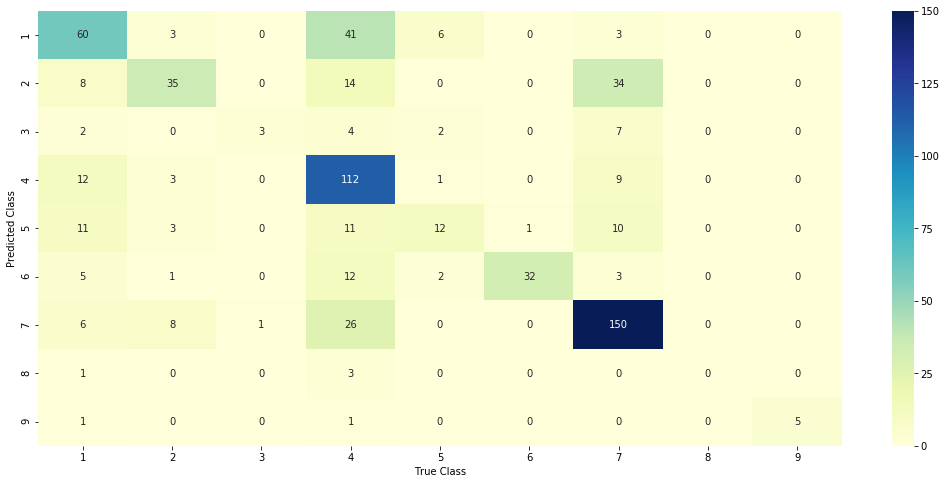

In [113]:
labels=[1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(18,8))
sns.heatmap(cm,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels,fmt='g')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.show()

In [114]:
acc=(np.trace(cm)/np.sum(cm)*100)
print("For KNN Neighbour Classifier (OneHotEncoding) we obtain {0:.2f}% of accuracy".format(round(acc,2)))

For KNN Neighbour Classifier (OneHotEncoding) we obtain 61.60% of accuracy


<span style="color:blue"><span style="font-size:20px">ProportionalEncoding</span></span>

In [115]:
neighbour = [7,8,9,10,11,12,13,14,15,16]

In [116]:
#KNNneighbours Classifier tuning with proportionalencoding
test_log_error_array=[]
for i in neighbour:
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(X_train_proportionalencoding, y_train)
    sig_model = CalibratedClassifierCV(model, method="sigmoid")
    sig_model.fit(X_train_proportionalencoding, y_train)
    y_pred = sig_model.predict_proba(X_test_proportionalencoding)
    test_log_error_array.append(log_loss(y_test, y_pred, labels=model.classes_, eps=1e-15))
    print("Neighbour's number value = {:>7}  log loss is: {:>12}".format(i,log_loss(y_test, y_pred, labels=model.classes_, eps=1e-15)))

Neighbour's number value =       7  log loss is: 1.0871780517972558
Neighbour's number value =       8  log loss is: 1.0747263675763796
Neighbour's number value =       9  log loss is: 1.0740651401003847
Neighbour's number value =      10  log loss is: 1.057920790167136
Neighbour's number value =      11  log loss is: 1.050984713087343
Neighbour's number value =      12  log loss is: 1.0419602914514612
Neighbour's number value =      13  log loss is: 1.0414239093038218
Neighbour's number value =      14  log loss is: 1.045743375825042
Neighbour's number value =      15  log loss is: 1.053630595160996
Neighbour's number value =      16  log loss is: 1.052714524466906


In [117]:
#KNN Neighbour Classifier best result using proportionalencoding
best_neighbour = np.argmin(test_log_error_array)
model = KNeighborsClassifier(n_neighbors=neighbour[best_neighbour])
model.fit(X_train_proportionalencoding, y_train)
sig_model = CalibratedClassifierCV(model, method="sigmoid")
sig_model.fit(X_train_proportionalencoding, y_train)

y_pred = sig_model.predict_proba(X_train_proportionalencoding)
print("Neighbour's number values =", neighbour[best_neighbour], "Train log loss is:",log_loss(y_train, y_pred, labels=model.classes_, eps=1e-15))

y_pred = sig_model.predict_proba(X_test_proportionalencoding)
print("Neighbour's number values =", neighbour[best_neighbour], "Test  log loss is:",log_loss(y_test, y_pred, labels=model.classes_, eps=1e-15))

Neighbour's number values = 13 Train log loss is: 0.3001630331731484
Neighbour's number values = 13 Test  log loss is: 1.0414239093038218


In [118]:
y_prediction =np.argmax(y_pred, axis=1)
y_prediction=y_prediction+1

In [119]:
cm=confusion_matrix(y_test,y_prediction)

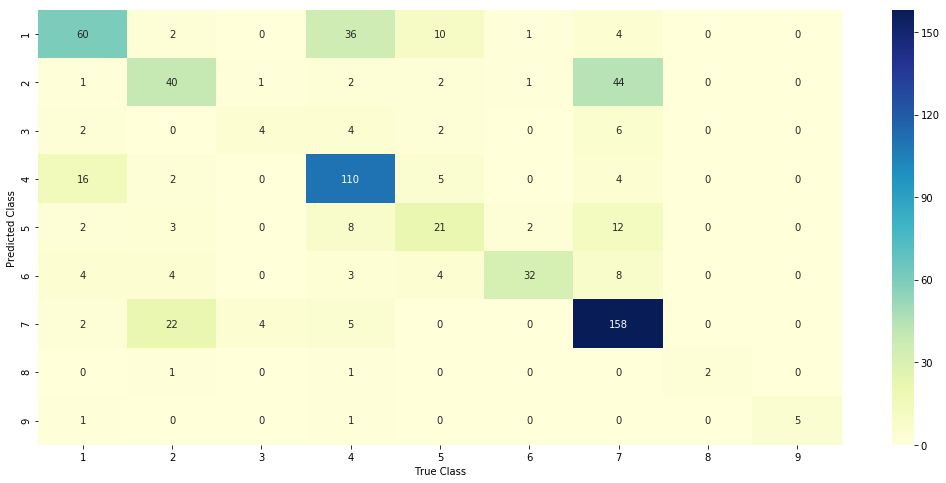

In [120]:
labels=[1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(18,8))
sns.heatmap(cm,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels,fmt='g')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.show()

In [121]:
acc=(np.trace(cm)/np.sum(cm)*100)
print("For KNN Neighbour Classifier (ProportionalEncoding) we obtain {0:.2f}% of accuracy".format(round(acc,2)))

For KNN Neighbour Classifier (ProportionalEncoding) we obtain 65.06% of accuracy


<span style="color:red"><span style="font-size:25px">Naive Bayes</span></span>

<span style="color:blue"><span style="font-size:20px">OneHotEncoding</span></span>

In [122]:
#Naive Bayes Classifier tuning with onehotencoding with all features
alpha = [0.0004,0.0005,0.0006,0.0007,0.0008]
test_log_error_array=[]
for i in alpha:
    model = MultinomialNB(alpha=i)
    model.fit(X_train_onehotencoding, y_train)
    sig_model = CalibratedClassifierCV(model, method="sigmoid")
    sig_model.fit(X_train_onehotencoding, y_train)
    y_pred = sig_model.predict_proba(X_test_onehotencoding)
    test_log_error_array.append(log_loss(y_test, y_pred, labels=model.classes_, eps=1e-15))
    print("Alpha value = {:>5}  log loss is: {:>12}".format(i,log_loss(y_test, y_pred, labels=model.classes_, eps=1e-15)))

Alpha value = 0.0004  log loss is: 1.2037246722859156
Alpha value = 0.0005  log loss is: 1.203336385253626
Alpha value = 0.0006  log loss is: 1.2026883344816566
Alpha value = 0.0007  log loss is: 1.2025714587001541
Alpha value = 0.0008  log loss is: 1.2039291249597082


In [125]:
#Naive Bayes Classifier best result using onehotencoding for all the features
best_alpha = np.argmin(test_log_error_array)
model = MultinomialNB(alpha=alpha[best_alpha])
model.fit(X_train_onehotencoding, y_train)
sig_model = CalibratedClassifierCV(model, method="sigmoid")
sig_model.fit(X_train_onehotencoding, y_train)

y_pred = sig_model.predict_proba(X_train_onehotencoding)
print("Alpha values =", alpha[best_alpha], "Train log loss is:",log_loss(y_train, y_pred, labels=model.classes_, eps=1e-15))

y_pred = sig_model.predict_proba(X_test_onehotencoding)
print("Alpha values =", alpha[best_alpha], "Test  log loss is:",log_loss(y_test, y_pred, labels=model.classes_, eps=1e-15))

Alpha values = 0.0007 Train log loss is: 0.9008766278369671
Alpha values = 0.0007 Test  log loss is: 1.2025714587001541


In [126]:
y_prediction =np.argmax(y_pred, axis=1)
y_prediction=y_prediction+1

In [127]:
cm=confusion_matrix(y_test,y_prediction)

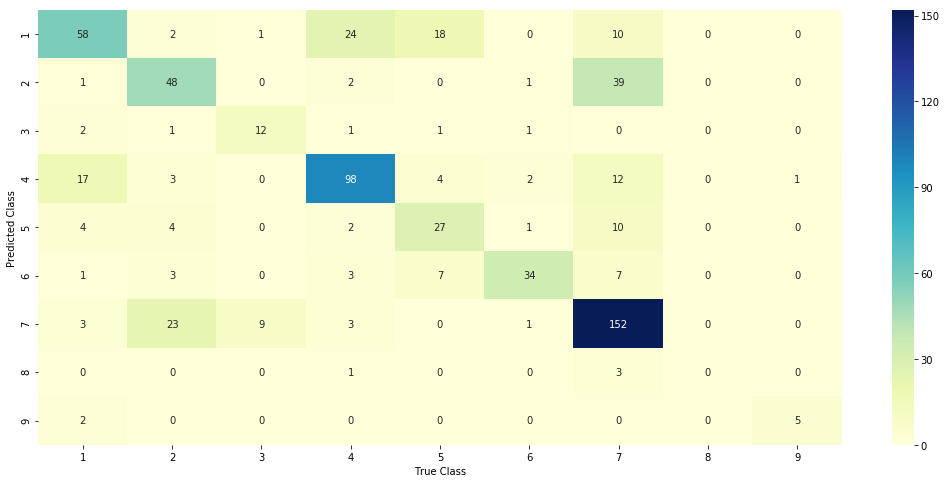

In [128]:
labels=[1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(18,8))
sns.heatmap(cm,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels,fmt='g')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.show()

In [129]:
acc=(np.trace(cm)/np.sum(cm)*100)
print("For Naive Bayes Classifier (OneHotEncoding) we obtain {0:.2f}% of accuracy".format(round(acc,2)))

For Naive Bayes Classifier (OneHotEncoding) we obtain 65.36% of accuracy


<span style="color:blue"><span style="font-size:20px">ProportionalEncoding</span></span>

In [130]:
#Naive Bayes Classifier tuning with proportionalencoding with all features
alpha = [0.000001,0.00001,0.0001]
test_log_error_array=[]
for i in alpha:
    model = MultinomialNB(alpha=i)
    model.fit(X_train_proportionalencoding, y_train)
    sig_model = CalibratedClassifierCV(model, method="sigmoid")
    sig_model.fit(X_train_proportionalencoding, y_train)
    y_pred = sig_model.predict_proba(X_test_proportionalencoding)
    test_log_error_array.append(log_loss(y_test, y_pred, labels=model.classes_, eps=1e-15))
    print("Alpha value = {:>5}  log loss is: {:>12}".format(i,log_loss(y_test, y_pred, labels=model.classes_, eps=1e-15)))

Alpha value = 1e-06  log loss is: 1.157555817307254
Alpha value = 1e-05  log loss is: 1.1575558718849064
Alpha value = 0.0001  log loss is: 1.1575564176865183


In [131]:
#Naive Bayes Classifier best result using proportionalencoding for all the features
best_alpha = np.argmin(test_log_error_array)
model = MultinomialNB(alpha=alpha[best_alpha])
model.fit(X_train_proportionalencoding, y_train)
sig_model = CalibratedClassifierCV(model, method="sigmoid")
sig_model.fit(X_train_proportionalencoding, y_train)

y_pred = sig_model.predict_proba(X_train_proportionalencoding)
print("Alpha values =", alpha[best_alpha], "Train log loss is:",log_loss(y_train, y_pred, labels=model.classes_, eps=1e-15))

y_pred = sig_model.predict_proba(X_test_proportionalencoding)
print("Alpha values =", alpha[best_alpha], "Test  log loss is:",log_loss(y_test, y_pred, labels=model.classes_, eps=1e-15))

Alpha values = 1e-06 Train log loss is: 0.9086174254587089
Alpha values = 1e-06 Test  log loss is: 1.157555817307254


In [132]:
y_prediction =np.argmax(y_pred, axis=1)
y_prediction=y_prediction+1

In [133]:
cm=confusion_matrix(y_test,y_prediction)

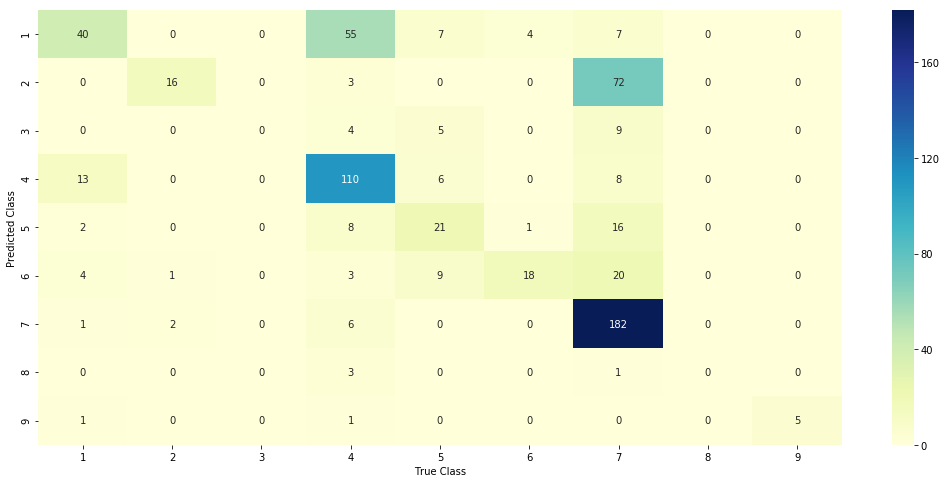

In [134]:
labels=[1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(18,8))
sns.heatmap(cm,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels,fmt='g')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.show()

In [135]:
acc=(np.trace(cm)/np.sum(cm)*100)
print("For Naive Bayes Classifier (ProportionalEncoding) we obtain {0:.2f}% of accuracy".format(round(acc,2)))

For Naive Bayes Classifier (ProportionalEncoding) we obtain 59.04% of accuracy


<span style="color:red"><span style="font-size:25px">Linear SVC Classifier</span></span>

<span style="color:blue"><span style="font-size:20px">OneHotEncoding</span></span>

In [136]:
#Linear SVC Classifier tuning with onehotencoding for all features
Cost = [0.01, 0.02, 0.03, 0.04, 0.05]
test_log_error_array=[]
for i in Cost:
    model = LinearSVC(C=i)
    model.fit(X_train_onehotencoding, y_train)
    sig_model = CalibratedClassifierCV(model, method="sigmoid")
    sig_model.fit(X_train_onehotencoding, y_train)
    y_pred = sig_model.predict_proba(X_test_onehotencoding)
    test_log_error_array.append(log_loss(y_test, y_pred, labels=model.classes_, eps=1e-15))
    print("Cost value = {:>5}  log loss is: {:>12}".format(i,log_loss(y_test, y_pred, labels=model.classes_, eps=1e-15)))

Cost value =  0.01  log loss is: 0.9743379989517295
Cost value =  0.02  log loss is: 0.969673580947326
Cost value =  0.03  log loss is: 0.9724200964358267
Cost value =  0.04  log loss is: 0.9768495560419808
Cost value =  0.05  log loss is: 0.9811558104638395


In [137]:
#Linear SVC best result using onehotencoding for all the features
best_cost = np.argmin(test_log_error_array)
model = LinearSVC(C=Cost[best_cost])
model.fit(X_train_onehotencoding, y_train)
sig_model = CalibratedClassifierCV(model, method="sigmoid")
sig_model.fit(X_train_onehotencoding, y_train)

y_pred = sig_model.predict_proba(X_train_onehotencoding)
print('Cost values = ', Cost[best_cost], "Train log loss is:",log_loss(y_train, y_pred, labels=model.classes_, eps=1e-15))

y_pred = sig_model.predict_proba(X_test_onehotencoding)
print('Cost values = ', Cost[best_cost], "Test log loss is:",log_loss(y_test, y_pred, labels=model.classes_, eps=1e-15))

Cost values =  0.02 Train log loss is: 0.6111290411990938
Cost values =  0.02 Test log loss is: 0.969673591758727


In [138]:
y_prediction =np.argmax(y_pred, axis=1)
y_prediction=y_prediction+1

In [139]:
cm=confusion_matrix(y_test,y_prediction)

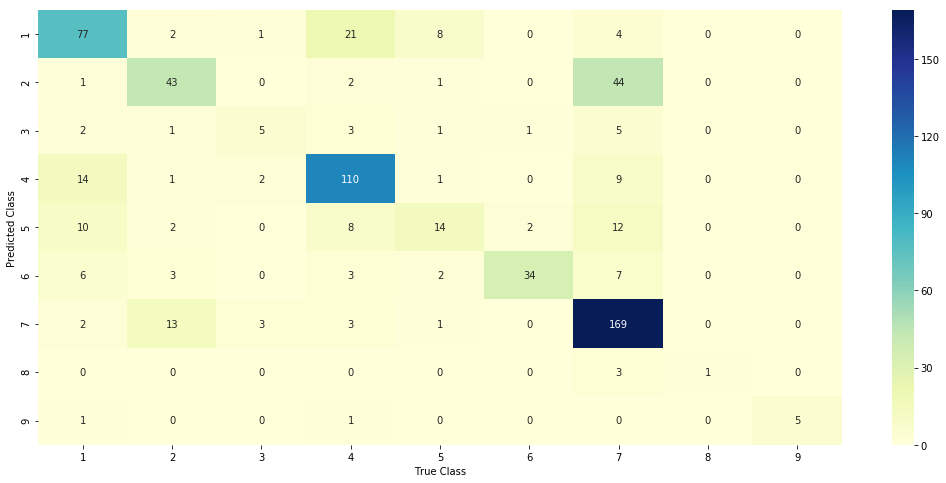

In [140]:
labels=[1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(18,8))
sns.heatmap(cm,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels,fmt='g')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.show()

In [141]:
acc=(np.trace(cm)/np.sum(cm)*100)
print("For Linear SVC Classifier (OneHotEncoding) we obtain {0:.2f}% of accuracy".format(round(acc,2)))

For Linear SVC Classifier (OneHotEncoding) we obtain 68.98% of accuracy


<span style="color:blue"><span style="font-size:20px">ProportionalEncoding</span></span>

In [142]:
#Linear SVC Classifier tuning with proportionalencoding for all the features
Cost = [0.0001, 0.001, 0.1, 1]
test_log_error_array=[]
for i in Cost:
    model = LinearSVC(C=i)
    model.fit(X_train_proportionalencoding, y_train)
    sig_model = CalibratedClassifierCV(model, method="sigmoid")
    sig_model.fit(X_train_proportionalencoding, y_train)
    y_pred = sig_model.predict_proba(X_test_proportionalencoding)
    test_log_error_array.append(log_loss(y_test, y_pred, labels=model.classes_, eps=1e-15))
    print("Cost value = {:>6}  log loss is: {:>12}".format(i,log_loss(y_test, y_pred, labels=model.classes_, eps=1e-15)))

Cost value = 0.0001  log loss is: 1.282011176750838
Cost value =  0.001  log loss is: 1.1899479214290447
Cost value =    0.1  log loss is: 1.20171747931967
Cost value =      1  log loss is: 1.2739062281436608


In [143]:
#Linear SVC Classifier best result using proportionalencoding for all the features
best_cost = np.argmin(test_log_error_array)
model = LinearSVC(C=Cost[best_cost])
model.fit(X_train_proportionalencoding, y_train)
sig_model = CalibratedClassifierCV(model, method="sigmoid")
sig_model.fit(X_train_proportionalencoding, y_train)

y_pred = sig_model.predict_proba(X_train_proportionalencoding)
print('Cost values = ', Cost[best_cost], "Train log loss is:",log_loss(y_train, y_pred, labels=model.classes_, eps=1e-15))

y_pred = sig_model.predict_proba(X_test_proportionalencoding)
print('Cost values = ', Cost[best_cost], "Test log loss is:",log_loss(y_test, y_pred, labels=model.classes_, eps=1e-15))

Cost values =  0.001 Train log loss is: 0.9651447318692041
Cost values =  0.001 Test log loss is: 1.1899478852767496


In [144]:
y_prediction =np.argmax(y_pred, axis=1)
y_prediction=y_prediction+1

In [145]:
cm=confusion_matrix(y_test,y_prediction)

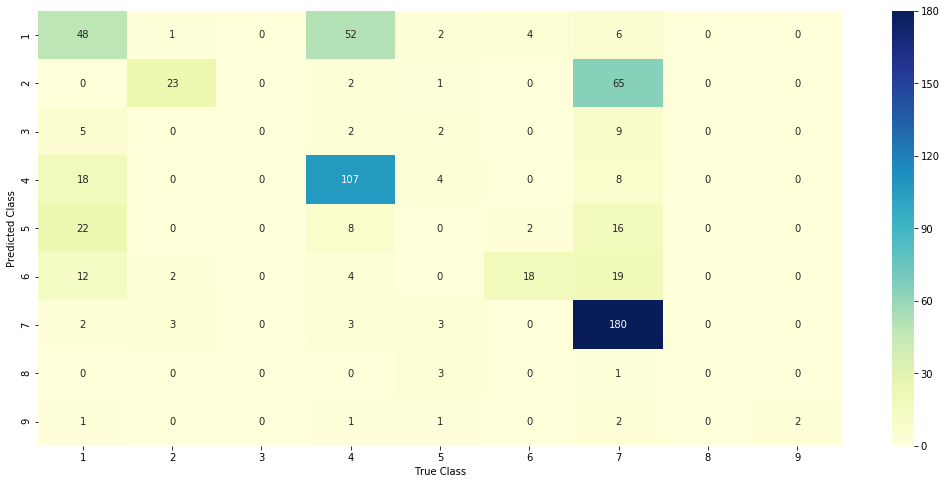

In [146]:
labels=[1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(18,8))
sns.heatmap(cm,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels,fmt='g')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.show()

In [147]:
acc=(np.trace(cm)/np.sum(cm)*100)
print("For Linear SVC Classifier (ProportionalEncoding) we obtain {0:.2f}% of accuracy".format(round(acc,2)))

For Linear SVC Classifier (ProportionalEncoding) we obtain 56.93% of accuracy


__We have tuned more different models with onehotencoding and proportionalencoding. Tree based models are very difficult to tune, specially in onehotencoding, because there are a lot of features and it takes a long time to calculate the results.__ 

__New model results do not improve previous results. It seems that SGDClassifier,Linear SVC and KNN give best results__

__Hereafter are the results:__<br><br>

<span style='color:blue'>
Linear SVC    : best log_loss= 0.9697<br>
SGDClassifier : best log_loss= 1.0334<br>
KNN           : best log_loss= 1.0414<br>
XGBoost       : best log_loss= 1.0663<br>
RandomForrest : best log_loss= 1.1245<br>
MultinomialNB : best log_loss= 1.1575<br>
</span>

__We must add that in real world log_loss can be a good indicator that how fine is our model but there is another metric which is very important in this medical case (missclassification%). The wrong classification of some mutations can be critical and in this case we obtain a best value of 31.02% missclassification for Linear SVC Classifier (OneHotEncoding).<br>
If we knew which missclassifications are the most critical ones, we could tune better the model__ 

Finally, we can try to check if results can be interpreted in some linear models. In several points in Naive Bayes model, we can notice that features significance can lead to predicted results.<br>
To check this assertion, we have generated a function that gives most significant features coefficient values. Then we test how many features of these significant features are included in test point. If test point has enough significant features, predicted value matches with actual value<br>

In [148]:
def significant_features(indices, text, gene, var, features_number):
    gene_vectorizer = CountVectorizer()
    variation_vectorizer = CountVectorizer()
    text_vectorizer = CountVectorizer(min_df=2)
    
    gene_vec = gene_vectorizer.fit(X_train['Gene'])
    var_vec  = variation_vectorizer.fit(X_train['Variation'])
    text_vec = text_vectorizer.fit(X_train['Text'])
    
    gene_len = len(gene_vec.get_feature_names())
    variation_len = len(var_vec.get_feature_names())
    
    feature_present = 0
    for i,v in enumerate(indices):
        #checking that feature index corresponds to gene feature
        if (v < gene_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                feature_present += 1
        #checking that feature index corresponds to variation feature        
        elif (v < gene_len+variation_len):
            word = var_vec.get_feature_names()[v-(gene_len)]
            yes_no = True if word == var else False
            if yes_no:
                feature_present += 1
        #checking that feature index corresponds to text feature          
        else:
            word = text_vec.get_feature_names()[v-(gene_len+variation_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                feature_present += 1

    print("Out of the top ",features_number," features ", feature_present, "are present in tested point")

In [149]:
model = MultinomialNB(alpha=0.0007)
model.fit(X_train_onehotencoding, y_train)
sig_model = CalibratedClassifierCV(model, method="sigmoid")
sig_model.fit(X_train_onehotencoding, y_train)

CalibratedClassifierCV(base_estimator=MultinomialNB(alpha=0.0007, class_prior=None, fit_prior=True),
            cv='warn', method='sigmoid')

In [151]:
y_test=y_test.values
test_point_number =70
feature_number= 100
predicted_point = sig_model.predict(X_test_onehotencoding[test_point_number])
print("Predicted Class :", predicted_point[0])
print("Predicted Class Probabilities:", np.round(sig_model.predict_proba(X_test_onehotencoding[test_point_number]),4))
print("Actual Class :", y_test[test_point_number])
indices = np.argsort(model.coef_)[predicted_point-1][:,-feature_number:]#we sort the first "feature_number" features indexes
print()
#we calculate how many significant features of test point are included in the first "feature_number" significant features
significant_features(indices[0], X_test['Text'].iloc[test_point_number],X_test['Gene'].iloc[test_point_number],X_test['Variation'].iloc[test_point_number],feature_number)

Predicted Class : 7
Predicted Class Probabilities: [[0.0939 0.0821 0.009  0.1155 0.0338 0.038  0.6202 0.0044 0.0033]]
Actual Class : 7

Out of the top  100  features  71 are present in tested point


In [152]:
#similar as previous code but in another test point
test_point_number =33
feature_number= 100
predicted_point = sig_model.predict(X_test_onehotencoding[test_point_number])
print("Predicted Class :", predicted_point[0])
print("Predicted Class Probabilities:", np.round(sig_model.predict_proba(X_test_onehotencoding[test_point_number]),4))
print("Actual Class :", y_test[test_point_number])
indices = np.argsort(model.coef_)[predicted_point-1][:,-feature_number:]
print()
significant_features(indices[0], X_test['Text'].iloc[test_point_number],X_test['Gene'].iloc[test_point_number],X_test['Variation'].iloc[test_point_number],feature_number)

Predicted Class : 5
Predicted Class Probabilities: [[0.1234 0.108  0.0116 0.1519 0.3996 0.0499 0.1455 0.0058 0.0043]]
Actual Class : 1

Out of the top  100  features  23 are present in tested point


We can see the more the predicted value and actual value matches, the more significant features are included in test point. Unfortunately, in some points of the same model this assertion is not so clear. Moreover, very often, higher values in model coefficients do not mean more significant features. It depends on normalisation, variance and other parameters related to each feature.

Some of the functions used mainly in proportional encoding have been modified from original functions given by Teclov Academy